In [2]:
%matplotlib inline
import os
import re
import json
import glob
import time
import random
import datetime
from collections import Counter

import torch
from torch.utils.data import DataLoader, Dataset
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from runtimestamp.runtimestamp import runtimestamp

runtimestamp()

Updated 2018-05-10 10:49:34.862764
By yvan
Using Python 3.6.5
On Linux-4.13.0-36-generic-x86_64-with-debian-stretch-sid


In [3]:
torch.__version__

'0.4.0'

## Data Parsing and Preprocessing

In [40]:
# Text-related global variables
max_seq_len = 30
min_word_freq = 20

# GPU variables
use_gpu = torch.cuda.is_available()
device_num = 1
device = torch.device(f"cuda:{device_num}" if use_gpu else "cpu")

# File-writing variables
today = datetime.datetime.now().strftime('%Y-%m-%d')
train_file = '/mnt/hdd2/leon_data/books/3body/en/all_three_train.csv'
valid_file = '/mnt/hdd2/leon_data/books/3body/en/all_three_valid.csv'
test_file = '/mnt/hdd2/leon_data/books/3body/en/all_three_test.csv'
model_dir = '/mnt/hdd2/leon_data/books/models/{}/'.format(today)
file_model = os.path.join(model_dir, '3body_LM__{}.json')
file_wv = os.path.join(model_dir, '3body_LM__wv__{}.txt')
os.makedirs(model_dir, exist_ok=True)

In [41]:
class IndexVectorizer:
    """
    Transforms a Corpus into lists of word indices.
    """
    def __init__(self, max_words=None, min_frequency=None, start_end_tokens=False, maxlen=None):
        self.vocabulary = None
        self.vocabulary_size = 0
        self.word2idx = dict()
        self.idx2word = dict()
        self.max_words = max_words
        self.min_frequency = min_frequency
        self.start_end_tokens = start_end_tokens
        self.maxlen = maxlen

    def _find_max_document_length(self, corpus):
        self.maxlen = max(len(document) for document in corpus)
        if self.start_end_tokens:
            self.maxlen += 2

    def _build_vocabulary(self, corpus):
        vocabulary = Counter(word for document in corpus for word in document)
        if self.max_words:
            vocabulary = {word: freq for word,
                          freq in vocabulary.most_common(self.max_words)}
        if self.min_frequency:
            vocabulary = {word: freq for word, freq in vocabulary.items()
                          if freq >= self.min_frequency}
        self.vocabulary = vocabulary
        self.vocabulary_size = len(vocabulary) + 2  # padding and unk tokens
        if self.start_end_tokens:
            self.vocabulary_size += 2

    def _build_word_index(self):
        self.word2idx['<PAD>'] = 0
        self.word2idx['<UNK>'] = 1

        if self.start_end_tokens:
            self.word2idx['<START>'] = 2
            self.word2idx['<END>'] = 3

        offset = len(self.word2idx)
        for idx, word in enumerate(self.vocabulary):
            self.word2idx[word] = idx + offset
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def fit(self, corpus):
        if not self.maxlen:
            self._find_max_document_length(corpus)
        self._build_vocabulary(corpus)
        self._build_word_index()

    def pad_document_vector(self, vector):
        padding = self.maxlen - len(vector)
        vector.extend([self.word2idx['<PAD>']] * padding)
        return vector

    def add_start_end(self, vector):
        vector.append(self.word2idx['<END>'])
        return [self.word2idx['<START>']] + vector

    def transform_document(self, document, offset=0):
        """
        Vectorize a single document
        """
        vector = [self.word2idx.get(word, self.word2idx['<UNK>']) 
                  for word in document]
        if len(vector) > self.maxlen:
            vector = vector[:self.maxlen]
        if self.start_end_tokens:
            vector = self.add_start_end(vector)
        vector = vector[offset:self.maxlen]
        
        return self.pad_document_vector(vector)

    def transform(self, corpus):
        """
        Vectorizes a corpus in the form of a list of lists.
        A corpus is a list of documents and a document is a list of words.
        """
        return [self.transform_document(document) for document in corpus]
    
    
class ThreeBodyDataset(Dataset):
    def __init__(self, path, vectorizer, tokenizer=None, stopwords=None):
        self.corpus = pd.read_csv(path)
        self.tokenizer = tokenizer
        self.vectorizer = vectorizer
        self.stopwords = stopwords
        self._tokenize_corpus()
        if self.stopwords: self._remove_stopwords() 
        self._vectorize_corpus()

    def _remove_stopwords(self):
        stopfilter = lambda doc: [word for word in doc if word not in self.stopwords]
        self.corpus['tokens'] = self.corpus['tokens'].apply(stopfilter)

    def _tokenize_corpus(self):
        if self.tokenizer:
            self.corpus['tokens'] = self.corpus['sentences'].apply(self.tokenizer)
        else:
            self.corpus['tokens'] = self.corpus['sentences'].apply(lambda x: x.lower().split())

    def _vectorize_corpus(self):
        if not self.vectorizer.vocabulary:
            self.vectorizer.fit(self.corpus['tokens'])
        self.corpus['vectors'] = self.corpus['tokens'].apply(self.vectorizer.transform_document)
        self.corpus['target'] = self.corpus['tokens'].apply(self.vectorizer.transform_document, offset=1)

    def __getitem__(self, index):
        sentence = self.corpus['vectors'].iloc[index]
        target = self.corpus['target'].iloc[index]
        return torch.LongTensor(sentence), torch.LongTensor(target)

    def __len__(self):
        return len(self.corpus)
    
def simple_tokenizer(text):
    return text.lower().split()

In [42]:
vectorizer = IndexVectorizer(max_words=None, min_frequency=min_word_freq, 
                             start_end_tokens=True, maxlen=max_seq_len)

training_set = ThreeBodyDataset(train_file, vectorizer, simple_tokenizer)
test_set = ThreeBodyDataset(test_file, vectorizer, simple_tokenizer)
validation_set = ThreeBodyDataset(valid_file, vectorizer, simple_tokenizer)

In [43]:
len(training_set), len(validation_set), len(test_set)

(10387, 1732, 1731)

In [44]:
print("Vocab size: {}".format(vectorizer.vocabulary_size))

Vocab size: 1194


In [45]:
training_set.corpus.iloc[0]

sentences    Purely in terms of command , humanity might ne...
tokens       [purely, in, terms, of, command, ,, humanity, ...
vectors      [2, 1, 4, 1, 5, 6, 7, 8, 9, 10, 11, 12, 1, 13,...
target       [1, 4, 1, 5, 6, 7, 8, 9, 10, 11, 12, 1, 13, 1,...
Name: 0, dtype: object

We'll divide our dataset into a training set and a test set.
We'll also create some functions for loading the data into batches.

In [46]:
def log(msg):
    print(msg)
    
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

class History(object):
    """Records Loss and Validation Loss"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.loss = dict()
        self.val_loss = dict()
        self.min_loss = 100
    
    def update_min_loss(self, min_loss):
        self.min_loss = min_loss
        
    def update_loss(self, loss):
        epoch = len(self.loss.keys())
        self.loss[epoch] = loss
    
    def update_val_loss(self, val_loss):
        epoch = len(self.val_loss.keys())
        self.val_loss[epoch] = val_loss
        
    def plot(self):
        loss = sorted(self.loss.items())
        x, y = zip(*loss)
        
        if self.val_loss:
            val_loss = sorted(self.val_loss.items())
            x1, y1 = zip(*val_loss)
            plt.plot(x, y, 'C0', label='Loss')
            plt.plot(x1, y1, 'C2', label='Validation Loss')
            plt.legend();
        else:
            plt.plot(x, y, 'C0');
    
def categorical_accuracy(y_true, y_pred):
    y_true = y_true.float()
    _, y_pred = torch.max(y_pred.squeeze(), dim=-1)
    return (y_pred.float() == y_true).float().mean()

def softmax_trick(x):
    logits_exp = torch.exp(x - torch.max(x))
    weights = torch.div(logits_exp, logits_exp.sum())
    return weights

def save_state_dict(model, filepath):
    '''Saves the model weights as a dictionary'''
    model_dict = model.state_dict()
    torch.save(model_dict, filepath)
    return model_dict

## LSTM Language Model
Here we'll define a recurrent language model.

In [47]:
class RNNLM(nn.Module):
    def __init__(self, vocab_size, seq_len, embedding_size, 
                 hidden_size, batch_size, 
                 dropout=.5, num_layers=1, tie_weights=False, 
                 bidirectional=False, word2idx={}, log_softmax=False):
       
        super(RNNLM, self).__init__()
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.batch_size = batch_size
        self.seq_len = seq_len
        self.tie_weights = tie_weights
        self.num_layers = num_layers
        self.num_directions = 1 if not bidirectional else 2
        self.word2idx = word2idx
        self.idx2word = {v:k for k,v in word2idx.items()}
        
        # Model Pieces
        self.dropout = nn.Dropout(p = dropout)
        self.log_softmax = nn.LogSoftmax(dim = 1) if log_softmax else None
        
        # Model Layers
        self.encoder = nn.Embedding(vocab_size, embedding_size, 
                                    padding_idx = word2idx.get('<PAD>', 1))
        
        self.lstm1 = nn.LSTM(embedding_size, hidden_size, 
                             num_layers = 1, 
                             bidirectional = bidirectional,
                             batch_first = True)
        
        self.lstm2 = nn.LSTM(hidden_size * self.num_directions, hidden_size, 
                             num_layers = 1, 
                             bidirectional = bidirectional,
                             batch_first = True)
        
        self.decoder = nn.Linear(hidden_size * self.num_directions, vocab_size)

        # tie enc/dec weights
        if self.tie_weights:
            if hidden_size != embedding_size:
                raise ValueError('When using the `tied` flag, hidden_size'
                                 'must be equal to embedding_dim')
            self.decoder.weight = self.encoder.weight
            
        self.init_weights()

        
    def init_hidden(self, bsz=None):
        '''
        For the nn.LSTM.
        Defaults to the batchsize stored in the class params, but can take in an argument
        in the case of sampling.
        '''
        if bsz == None: 
            bsz = self.batch_size
        h0 = torch.zeros(self.num_layers * self.num_directions, 
                         bsz, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * self.num_directions, 
                         bsz, self.hidden_size ).to(device)
        return (h0, c0)
    
    
    def init_weights(self):
        initrange = 0.1
        em_layer = [self.encoder]
        lin_layers = [self.decoder]
        for layer in lin_layers + em_layer:
            layer.weight.data.uniform_(-initrange, initrange)
            if layer in lin_layers:
                layer.bias.data.fill_(0)
    
    
    def sample(self, x_start):
        '''
        Generates a sequence of text given a starting word ix and hidden state.
        '''
        with torch.no_grad():
            indices = [x_start]
            for i in range(self.seq_len):
                # create inputs
                x_input = torch.LongTensor(indices).to(device)
                x_embs = self.encoder(x_input.view(1, -1))

                # send input through the rnn
                output, hidden = self.lstm1(x_embs)
                output, hidden = self.lstm2(output, hidden)

                # format the last word of the rnn so we can softmax it.
                one_dim_last_word = output.squeeze()[-1] if i > 0 else output.squeeze()
                fwd = one_dim_last_word[ : self.hidden_size ]
                bck = one_dim_last_word[ self.hidden_size : ]

                # pick a word from the disto
                word_weights = softmax_trick(fwd)
                word_idx = torch.multinomial(word_weights, num_samples=1).squeeze().item()
                indices.append(word_idx)

        return indices
    
    
    def forward(self, x, hidden, log_softmax=False):
        '''
        Iterates through the input, encodes it.
        Each embedding is sent through the step function.
        Dropout the last hidden layer and decode to a logit
        x.size() #(bsz, seq_len)
        
        logit.size # (bsz, seq_len, vocab_size)
        equivalent to (output.size(0), output.size(1), logit.size(1)
        '''
        x_emb = self.encoder(x)
        
        output, hidden = self.lstm1(x_emb, hidden)
        output, hidden = self.lstm2(self.dropout(output), hidden)
        
        logit = self.decoder(self.dropout(output))
        if self.log_softmax:
            logit = self.log_softmax(logit)
        logit = logit.view(logit.size(0) * self.seq_len, self.vocab_size)
        
        return logit, hidden

In [48]:
def run_epoch(model, dataset, criterion, optim, batch_size, 
              train=False, shuffle=True):
    '''A wrapper for a training, validation or test run.'''
    model.train() if train else model.eval()
    loss = AverageMeter()
    accuracy = AverageMeter()
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    for X, y in loader:
        model.zero_grad() 
        X = X.squeeze().to(device)
        y = y.squeeze().view(-1).to(device)

        # get a predition    
        hidden = model.init_hidden(X.size(0))
        y_, hidden = model(X, hidden)
        
        # calculate loss and accuracy
        lossy = criterion(y_.squeeze(), y.squeeze())
        accy = categorical_accuracy(y_.squeeze().data, y.squeeze().data)
        
        loss.update(lossy.data.item())
        accuracy.update(accy)
        
        # backprop
        if train:
            lossy.backward()
            optim.step()
    
    return loss.avg, accuracy.avg


def training_epoch(*args, **kwargs):
    '''Training Epoch'''
    return run_epoch(train=True, *args, **kwargs)
    
    
def validation_epoch(*args, **kwargs):
    '''Validation Epoch'''
    return run_epoch(*args, **kwargs)
 
    
def sample_lm(model):
    '''Samples a language model and returns generated words'''
    start_idx = model.word2idx['<START>']
    indices = model.sample(start_idx)
    words = [model.idx2word[index] for index in indices]
    
    return words


def training_loop(batch_size, num_epochs, display_freq, model, criterion, 
                  optim, training_set, validation_set=None, 
                  best_model_path='model', history=None):
    '''Training iteration.'''
    if not history:
        history = History()
    
    try: 
        for epoch in tqdm(range(num_epochs)):
            loss, accuracy = training_epoch(model, training_set, criterion, optim, batch_size)
            history.update_loss(loss)
            
            if validation_set:
                val_loss, val_accuracy = validation_epoch(model, validation_set, 
                                                          criterion, optim, batch_size)  
                history.update_val_loss(val_loss)
                if val_loss < history.min_loss:
                    save_state_dict(model, best_model_path)
                    history.update_min_loss(val_loss)
            else:
                if loss < history.min_loss:
                    save_state_dict(model, best_model_path)
                    history.update_min_loss(loss)
                
            if epoch % display_freq == 0:
                # display stats
                if validation_set:
                    log("Epoch: {:04d}; Loss: {:.4f}; Val-Loss {:.4f}; "
                        "Perplexity {:.4f}; Val-Perplexity {:.4f}".format(
                            epoch, loss, val_loss, np.exp(loss), np.exp(val_loss)))
                else:
                    log("Epoch: {:04d}; Loss: {:.4f}; Perplexity {:.4f};".format(
                            epoch, loss, np.exp(loss)))
                
                # sample from the language model
                words = sample_lm(model)
                log("Sample: {}".format(' '.join(words)))
                time.sleep(1)
        
        log('-' * 89)
        log("Training complete")
        log("Lowest loss: {:.4f}".format(history.min_loss))
        
        return  history
        
    except KeyboardInterrupt:
        log('-' * 89)
        log('Exiting from training early')
        log("Lowest loss: {:.4f}".format(history.min_loss))

        return history

## Training the Model
We'll declare hyperparameters here, instantiate our model, create a training set data batcher, and train our model.

In [52]:
# Set Seed
if use_gpu: torch.cuda.manual_seed(303)
else: torch.manual_seed(303)

# set up Files to save stuff in
runtime = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
file_model = file_model.format(runtime)
file_wv = file_wv.format(runtime)
    
# Model Hyper Parameters 
hidden_dim = 100
embedding_dim = 200
batch_size = 512
dropout = 0.2
lstm_layers = 1 # this is useless atm
lstm_bidirection = True

# Training
learning_rate = 1e-4
num_epochs = 300
display_epoch_freq = 10

# Build and initialize the model
lm = RNNLM(vectorizer.vocabulary_size, max_seq_len, embedding_dim, hidden_dim, batch_size, 
           dropout = dropout, 
           tie_weights = False, 
           num_layers = lstm_layers, 
           bidirectional = lstm_bidirection, 
           word2idx = vectorizer.word2idx,
           log_softmax = True)

if use_gpu:
    lm = lm.to(device)
lm.init_weights()

# Loss and Optimizer
loss = nn.NLLLoss()
optimizer = torch.optim.Adam(lm.parameters(), lr=learning_rate)

# Train the model
history = training_loop(batch_size, num_epochs, display_epoch_freq, 
                        lm, loss, optimizer, training_set, validation_set, 
                        best_model_path=file_model)

Epoch: 0000; Loss: 3.3905; Val-Loss 3.3774; Perplexity 29.6801; Val-Perplexity 29.2938
Sample: <START> day about away they quickly morning lit away these image use use day in three quickly - . command <START> by see but transmission this her this <PAD> something transmission



Exception in thread Thread-7:
Traceback (most recent call last):
  File "/home/yvan/anaconda3/envs/leon_pytorch/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/yvan/anaconda3/envs/leon_pytorch/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/home/yvan/anaconda3/envs/leon_pytorch/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



Epoch: 0010; Loss: 2.7412; Val-Loss 2.7036; Perplexity 15.5052; Val-Perplexity 14.9334
Sample: <START> soon cigarette star his ji luo an about history had <PAD> got might but command in this children walking was children an when and quickly but with centuries star glanced
Epoch: 0020; Loss: 2.6513; Val-Loss 2.6180; Perplexity 14.1722; Val-Perplexity 13.7078
Sample: <START> space , . her see transmission time walking several <PAD> his it edge speed seemed not walking was might out display it , something lit and can morning up soon
Epoch: 0030; Loss: 2.3643; Val-Loss 2.3149; Perplexity 10.6371; Val-Perplexity 10.1237
Sample: <START> <END> was ! they when turned five universe this these <START> a quickly seemed display lit of but several never wang he held its want about by use something red
Epoch: 0040; Loss: 2.0659; Val-Loss 2.0162; Perplexity 7.8925; Val-Perplexity 7.5095
Sample: <START> as wang humanity already see time look in walking can by five up <END> red with turned space away y

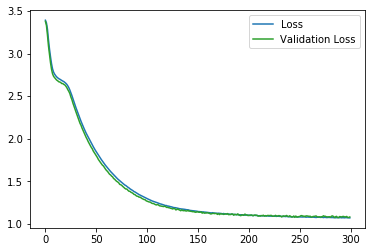

In [53]:
history.plot()

In [54]:
def test_loop(batch_size, model, criterion, optim, test_set,):
    '''Data iterator for the test set'''
    model.eval()
    
    try:
        test_loss, test_accuracy = validation_epoch(model, test_set, 
                                                    criterion, optim, batch_size)
        log('Evaluation Complete')
        log('Test set Loss: {}'.format(test_loss))
        log('Test set Perplexity: {}'.format(np.exp(test_loss)))
        log('Test set Accuracy: {}'.format(test_accuracy))
    
    except KeyboardInterrupt:
        log('-' * 89)
        log('Exiting from testing early')

In [55]:
lm.load_state_dict(torch.load(file_model))
test_loop(256, lm, loss, optimizer, test_set)

Evaluation Complete
Test set Loss: 1.0961862802505493
Test set Perplexity: 2.992730795887753
Test set Accuracy: 0.0


## Saving Embeddings Weights
1. Extrcting vectors into a dictionary (`word2vec`)
2. Saving the vectors (`word2vec`).

In [64]:
def get_elmo_vectors(model):
    model.eval()
    word2vec = {}
    for w, ix in tqdm(model.word2idx.items()):
        ix_var = torch.LongTensor([ix]).to(device)

        emb = model.encoder(ix_var.view(1,-1))
        out1, hid_ = model.lstm1(emb)
        out2, hid_ = model.lstm2(out1, hid_)
        
        emb = emb.view(1,-1).data.cpu().numpy()[0]
        out1 = out1.view(1,-1).data.cpu().numpy()[0]
        out2 = out2.view(1,-1).data.cpu().numpy()[0]

        word2vec[w] = dict(
            embedding = emb,
            hid1 = out1,
            hid2 = out2,
        )
        
    return word2vec

In [65]:
word2vec = get_elmo_vectors(lm)

In [58]:
with open(file_wv, 'w+') as f:
    for w, vec in tqdm(word2vec.items()):
        row = np.concatenate([[w], vec['embedding'], vec['hid1'], vec['hid2']])
        f.write(' '.join(row) + '\n')

In [59]:
' '.join(row)

'doomsday 0.019144375 -0.011262503 -0.054264653 0.07552316 -0.04677312 -0.043715246 0.029800449 -0.098677255 -0.087699786 0.111737646 0.08108406 0.08127617 0.14914002 -0.17581704 0.010354878 0.12268086 -0.08209066 -0.03954192 -0.009683989 0.060234316 0.079789676 -0.11663191 0.124724835 -0.037095707 0.04702442 -0.029397946 -0.12079265 -0.10139638 0.0095835645 0.113344245 0.08293821 0.100370824 -0.008190885 0.008966734 0.021829829 -0.08489138 0.10120566 -0.010230141 -0.04472376 -0.10047493 -0.0625175 -0.055764224 0.1547271 -0.1139233 -0.057975918 -0.11362845 -0.047995884 -0.028644199 0.031366825 0.09102691 0.0064217034 0.0591397 -0.034809817 -0.030157201 -0.055808205 0.017484395 0.057290915 0.056935456 0.04440339 0.03640528 0.061410222 -0.06576907 -0.066208206 0.009575155 0.09143286 -0.10088797 -0.08211959 0.059557542 -0.035395663 0.024542004 -0.035210326 0.014628755 0.12772882 -0.057329144 -0.0744061 -0.02468062 0.009410101 -0.04309125 -0.084312454 0.0762925 -0.020742945 0.04448962 0.12